# Algotytm przecinania się odcinków na płaszczyźnie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test4 import Test
from bitalg.visualizer.main import Visualizer

# Definicja stałych

In [2]:
# nieskończoność
INF = float("inf")

# generowanie odcinków
MIN_X = 0
MIN_Y = 0

# porównywanie punktów
EPS = 10 ** -12

# typy zdarzeń
BEG = 0
END = 1
INTERSECT = 2

# konfiguracja wizualizacji
BROOM = {"color" : "red", "linestyle" : '--', "linewidth" : 2}
IN_EVENTS_STRUCT = {"color" : ["green"]}
CURRENT_VERTEX = {"color" : ["cyan"]}
PROCESSED_VERTICIES = {"color" : ["blue"]}
FOUND_INTERSECTION_POINT = {"color" : ["red"], "s" : 70}
IN_BROOM_STRUCT = {"color" : ["purple"]}
PROCESSED_SEGMENTS = {"color" : ["blue"]}
NOT_PROCESSED_SEGMENTS = {"color" : ["orange"]}

# Przydatne funkcje 

In [3]:
def draw_example_1():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))

    vis.add_line_segment(line_segments)
    vis.show()

def draw_example_2():
    vis = Visualizer()
    line_segments = ((-0.5, 0.5), (8.5, 3.5),
                     (1, 3), (7, 5),
                     (2, 4), (5, 1),
                     (4.5, 3), (6.5, 6),
                     (0, 5), (5.5, 5.5))
    points = [(4, 2),
              (2.5, 3.5),
              (5.5, 4.5)]

    vis.add_line_segment(line_segments)
    vis.add_point(points, color='red')
    vis.show()


In [4]:
def draw_segments(segments):
    plt.close("all")
    vis = Visualizer()
    vis.add_line_segment(segments)
    vis.show()

In [5]:
def draw_intersections(segments, intersections):
    plt.close("all")
    vis = Visualizer()
    vis.add_line_segment(segments)
    vis.add_point(intersections, **FOUND_INTERSECTION_POINT)
    vis.show()

## Wprowadzenie
Celem ćwiczenia jest implementacja i zapoznanie się z algorytmem wyznaczającym wszystkie przecięcia się odcinków na płaszczyźnie

### Przykładowy zbiór odcinków przed wyznaczeniem punktów przecięcia

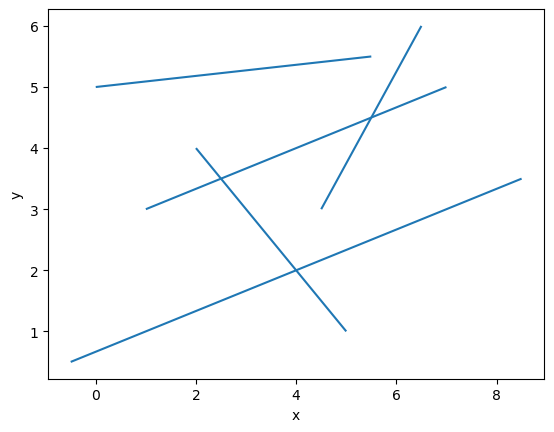

In [6]:
draw_example_1()

### Przykładowy zbiór odcinków po wyznaczenu punktów przecięcia

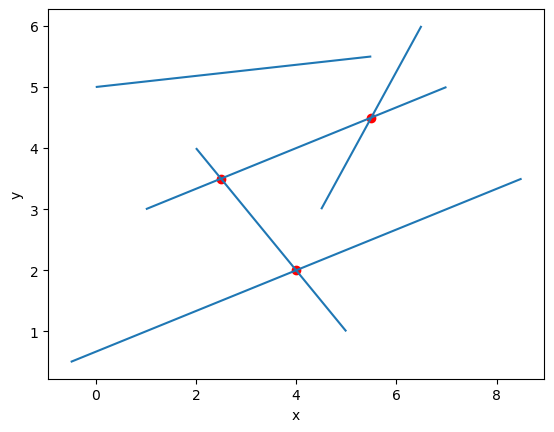

In [7]:
draw_example_2()

## Generowanie losowych odcinków na płaszczyźnie

Uzupełnij funkcję ```generate_uniform_sections```

In [8]:
import random

In [9]:
def generate_uniform_sections(max_x, max_y, n):
    """
    Funkcja generuje odcinki o współrzędnych rzeczywistych w postaci par punktów.
    Żaden wygenerowany odcinek nie jest odcinkiem pionowym.
    Żadne dwa odcinki nie mają swoich końców o takiej samej współrzędnej x.
    Zakres współrzędnych: x -> (0, max_x), y -> (0, max_y)
    :param max_x: określa maksymalną wartość współrzednej x jaka może zostać wylosowana
    :param max_y: określa maksymalną wartość współrzednej y jaka może zostać wylosowana
    :param n: ilość generowanych odcinków
    :return: tablica odcinków w postaci krotek zawierających parę krotek współrzędnych punktów końcowych odcinków
    np. [((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)),...]
    """

    uniformSections = []
    sectionsEndsXCoordinate = set()

    while len(uniformSections) < n:
        x1 = random.uniform(MIN_X, max_x)
        x2 = random.uniform(MIN_X, max_x)

        if x1 == x2 or x1 in sectionsEndsXCoordinate or x2 in sectionsEndsXCoordinate:
            continue

        sectionsEndsXCoordinate.add(x1)
        sectionsEndsXCoordinate.add(x2)

        y1 = random.uniform(MIN_Y, max_y)
        y2 = random.uniform(MIN_Y, max_y)

        section = ((x1, y1), (x2, y2))
        uniformSections.append(section)

    return uniformSections

In [10]:
Test().runtest(1, generate_uniform_sections)

Lab 4, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.096s


<span style="color:red">Ćw.</span> Wygeneruj $\large20$ losowych odcinków w przestrzeni 2D o współrzędnych z przedziału $\large x \in \langle 0,1000 \rangle$ oraz $\large y \in \langle 0,1000\rangle$. 

In [11]:
sections = generate_uniform_sections(1000, 1000, 20)

Zwizualizuj otrzymane odcinki

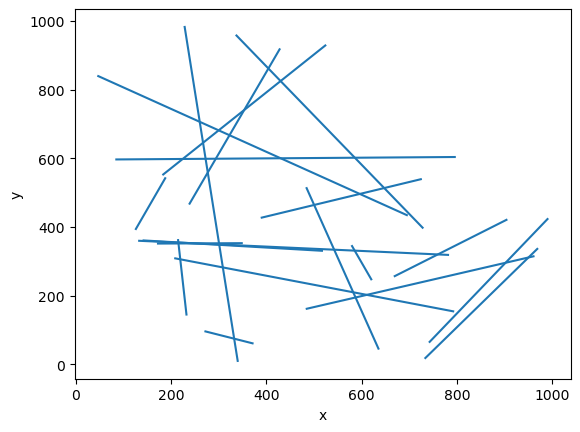

In [12]:
%matplotlib inline
draw_segments(sections)

## Wprowadzenie odcinków myszką

Uzupełnij funkcję ```get_segments``` #interaktywne dodawanie odcinków przez rysowanie myszką

In [13]:
def get_segments():
    """
    Odczytuje punkty wprowadzone przez użytkownika myszką i zwraca listę odcinków jako krotki punktów, które są
    krotkami liczb zmiennoprzecinkowych.
    Wewnątrz Jupyter Notebook używać wraz z ***%matplotlib widget***

    :return list of tuple: Lista, w której każdy element jest krotką krotek reprezentujących odcinki ((x1, y1), (x2, y2)).
    """
    # Event handler for mouse click
    def on_click(event):
        nonlocal pickSegmentBeg, segmentBegX, segmentBegY
        # Check if it's a left-click within the axes
        if event.button == 1 and event.inaxes == ax:
            # Append the point and update the plot
            currX, currY = event.xdata, event.ydata
            ax.scatter(currX, currY, color = "blue", marker = 'o')  # Mark the point

            # check if it is first or second point in line segment
            if pickSegmentBeg:
                segmentBegX, segmentBegY = currX, currY
            else:
                xs = [segmentBegX, currX]
                ys = [segmentBegY, currY]
                ax.plot(xs, ys, color = "blue")
                segment = ((segmentBegX, segmentBegY), (currX, currY))
                segments.append(segment)

            # update information about point type
            pickSegmentBeg = not pickSegmentBeg

            # update plot
            plt.draw()

        # If right-click, close the polygon by connecting to the first point
        elif event.button == 3 and pickSegmentBeg:
            plt.draw()
            fig.canvas.mpl_disconnect(cid)  # Disconnect the event
            # plt.close(fig)

    plt.close('all')    # close all opened plots

    segments = []
    pickSegmentBeg = True
    segmentBegX, segmentBegY = None, None

    fig, ax = plt.subplots(num = "get line segments")
    ax.set_title("Left-click to select points; right-click to finish")

    # Connect the event handler
    cid = fig.canvas.mpl_connect('button_press_event', on_click)

    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.show()

    return segments

Dodaj odcinki wprowadzając je myszką

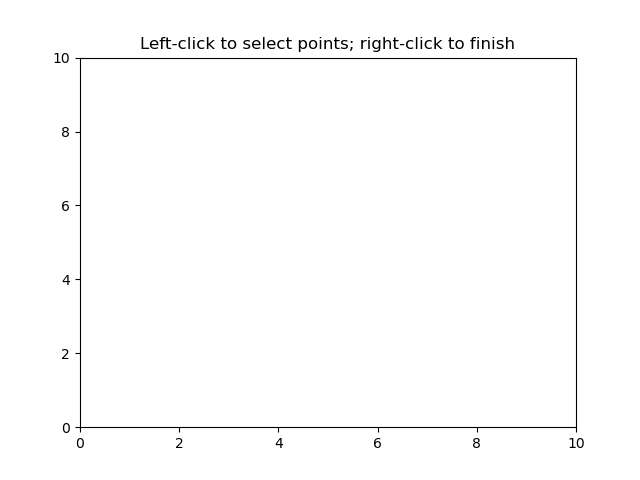

In [14]:
%matplotlib widget
segments = get_segments()

Zwizualizuj wprowadzone odcinki

[((np.float64(1.0483870967741935), np.float64(8.582251082251084)), (np.float64(8.689516129032258), np.float64(5.2813852813852815))), ((np.float64(2.7822580645161294), np.float64(2.1969696969696972)), (np.float64(6.370967741935484), np.float64(7.472943722943723))), ((np.float64(3.2056451612903225), np.float64(8.988095238095239)), (np.float64(5.625), np.float64(3.54978354978355))), ((np.float64(4.193548387096774), np.float64(1.3582251082251084)), (np.float64(8.669354838709676), np.float64(0.8170995670995671))), ((np.float64(6.794354838709676), np.float64(0.49242424242424243)), (np.float64(2.056451612903226), np.float64(4.442640692640693))), ((np.float64(0.9879032258064515), np.float64(6.634199134199134)), (np.float64(7.580645161290322), np.float64(4.9025974025974035)))]


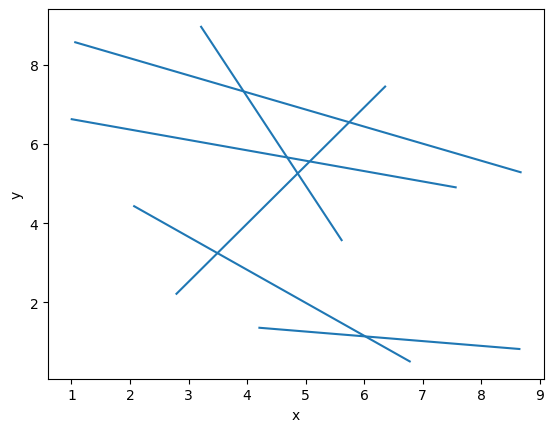

In [15]:
%matplotlib inline
draw_segments(segments)
print(segments)

## Wczytywanie odcinków z pliku

In [16]:
def load_segments_from_file(pathToFile: str):
    loadedSegments = []
    try:
        with open(pathToFile, 'r') as file:
            for line in file:
                beg1, end1, beg2, end2 = list(map(np.float64, line.strip().split()))
                loadedSegments.append(((beg1, end1), (beg2, end2)))
    except FileNotFoundError:
        print(f"File '{pathToFile}' not found.")
    except ValueError:
        print("Invalid format in file. Each line should contain four floats separated by whitespace.")

    return loadedSegments

In [17]:
pathToFile = "./test_segments/test1"
loadedSegments1 = load_segments_from_file(pathToFile)

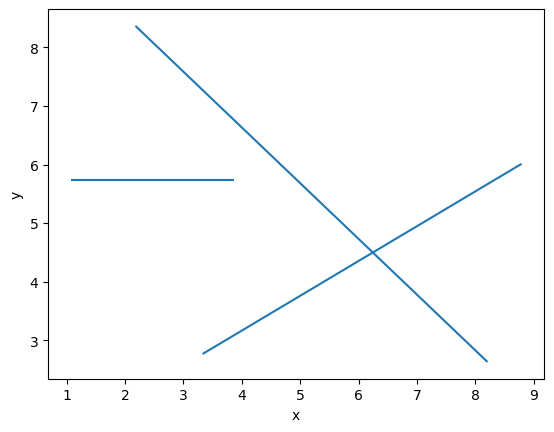

In [18]:
draw_segments(loadedSegments1)

## Wykorzystywane struktury

In [19]:
from sortedcontainers import SortedSet

In [20]:
class Point:
    def __init__(self, point: tuple[float, float]) -> None:
        self.point = point

    def get_point(self):
        return self.point

    def get_x(self):
        return self.point[0]

    def get_y(self):
        return self.point[1]

    def __lt__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        return self.get_x() < other.get_x()

    def __le__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        return self.get_x() <= other.get_x()

    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Point):
            return NotImplemented
        return self.point == value.point

    def __hash__(self) -> int:
        return hash(self.point)

    def __repr__(self) -> str:
        return f"Point({self.get_x()}, {self.get_y()})"

In [21]:
class Segment:
    # współdzielona wartość obecnej wpółrzędnej x

    x = None

    def __init__(self, idx: int, beg: Point, end: Point) -> None:
        self.idx = idx

        # ustawienie początku jako punktu z mniejszą wartością współrzędnej x
        if end < beg:
            beg, end = end, beg

        self.beg = beg
        self.end = end

        # wyznaczenie współczynników a i b do równania kierunkowego prostej
        self.a = (end.get_y() - beg.get_y()) / (end.get_x() - beg.get_x())
        self.b = -self.a * beg.get_x() + beg.get_y()

    @staticmethod
    def update_x(x):
        Segment.x = x

    def get_segment(self):
        return (self.beg.get_point(), self.end.get_point())

    def get_idx(self):
        return self.idx

    def get_beg(self):
        return self.beg

    def get_end(self):
        return self.end

    def get_a(self):
        return self.a

    def get_b(self):
        return self.b

    def calculate_y_coordinate(self):
        return self.a * Segment.x + self.b

    def __lt__(self, other):
        if not isinstance(other, Segment):
            return NotImplemented

        thisY = self.calculate_y_coordinate()
        otherY = other.calculate_y_coordinate()

        return thisY < otherY

    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Segment):
            return NotImplemented
        return self.get_beg() == value.get_beg() and self.get_end() == value.get_end()

    def __hash__(self) -> int:
        return hash((self.beg, self.end))

    def __repr__(self) -> str:
        return f"Segment({self.beg}, {self.end})"

In [22]:
class Event:
    def __init__(self, point: Point, eventType, segmentsList: list[Segment]) -> None:
        self.point = point
        self.eventType = eventType
        self.segmentsList = segmentsList

    def get_event_point(self):
        return self.point

    def get_event_type(self):
        return self.eventType

    def get_event_segments_list(self):
        return self.segmentsList

    def __lt__(self, other) -> bool:
        if not isinstance(other, Event):
            return NotImplemented
        return self.point.__lt__(other.get_event_point())

    def __le__(self, other) -> bool:
        if not isinstance(other, Event):
            return NotImplemented
        return self.point.__le__(other.get_event_point())

    def __eq__(self, value: object) -> bool:
        if not isinstance(value, Event):
            return NotImplemented
        return self.eventType == value.eventType and self.get_event_point() == value.get_event_point()

    def __hash__(self) -> int:
        return hash((self.point, self.eventType))

    def __repr__(self) -> str:
        return f"Event({self.point, self.eventType})"

Uzupełnij funkcję ```get_segments_intersection``` znajdującą przecięcie dwóch odcinków

In [23]:
def mat_det_2x2(kx1, kx2, ky1, ky2):
    """
    Obliczanie wyznacznika macierzy 2x2 bez użycia funkcji bibliotecznych

    :param kx1: współczynnik przed x w pierwszym równaniu
    :param kx2: współczynnik przed x w drugim równaniu
    :param ky1: współczynnik przed y w pierwszym równaniu
    :param ky2: współczynnik przed y w drugim równaniu
    :return: wartość wyznacznika macierzy
    """

    return kx1 * ky2 - kx2 * ky1

In [24]:
def get_segments_intersection(segment1: Segment, segment2: Segment) -> Point:
    """
    Wyznacza punkt przecięcia odcinków

    :param segment1: pierwszy odcinek
    :param segment2: drugi odcinek
    :return: punkt przecięcia odcinków
    """
    if segment1.get_a() == segment2.get_a():
        return None

    W = mat_det_2x2(segment1.get_a(), segment2.get_a(), -1, -1)
    Wx = mat_det_2x2(-segment1.get_b(), -segment2.get_b(), -1, -1)
    Wy = mat_det_2x2(segment1.get_a(), segment2.get_a(), -segment1.get_b(), -segment2.get_b())

    intersectPoint = Point((Wx / W, Wy / W))

    if segment1.get_beg().get_x() < intersectPoint.get_x() < segment1.get_end().get_x() \
       and segment2.get_beg().get_x() < intersectPoint.get_x() < segment2.get_end().get_x():
        return intersectPoint

    return None

## Przecinanie się odcinków

Uzupełnij funkcję ```is_intersection```

In [25]:
def is_intersection_handle_event_beg(event: Event, broomStateStruct: SortedSet):
    foundIntersection = False
    eventSegment = event.get_event_segments_list()[0]
    broomStateStruct.add(eventSegment)
    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None:
            foundIntersection = True

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None:
            foundIntersection = True

    return foundIntersection

In [26]:
def is_intersection_handle_event_end(event: Event, broomStateStruct: SortedSet):
    foundIntersection = False
    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)
    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None:
            foundIntersection =True

    broomStateStruct.remove(toRemoveSegment)

    return foundIntersection

In [27]:
def is_intersection(segments, eps = EPS):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina

    :param sections: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :param eps: epsilon będący dokładnością, z jaką porównujemy liczby zmiennoprzecinkowe
    :return: True / False
    """

    isIntersection = False

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segments = [Segment(None, Point(beg), Point(end)) for beg, end in segments]

    for seg in segments:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)

    firstEvent: Event = eventsSortedSet.pop(0)
    broomStateStruct.add(firstEvent.get_event_segments_list()[0])

    while len(eventsSortedSet) > 0:
        event: Event = eventsSortedSet.pop(0)
        eventType = event.get_event_type()

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(event.get_event_point().get_x())

        if eventType == BEG:
            if is_intersection_handle_event_beg(event, broomStateStruct):
                isIntersection = True
                break
        elif eventType == END:
            if is_intersection_handle_event_end(event, broomStateStruct):
                isIntersection = True
                break
        else:
            raise Exception("Unknow Event type")

    return isIntersection

In [28]:
isIntersection = is_intersection(segments)
print(isIntersection)

True


In [29]:
isIntersection = is_intersection(loadedSegments1)
print(isIntersection)

True


In [30]:
Test().runtest(2, is_intersection)

Lab 4, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
Result: 3/3
Time: 0.002s


### W jaki sposób zaimplementowałeś struktura stanu (stan miotły) oraz struktura zdarzeń w Twoim programie?

In [31]:
# Odpowiedź here
# TODO: answer

Uzupełnij funkcję ```is_intersection_with_visualization```

In [32]:
def get_broom(point: Point):
    return ((point.get_x(), 0), (point.get_x(), 1))

In [33]:
def is_intersection_with_visualization_handle_event_beg(event: Event, broomStateStruct: SortedSet, vis: Visualizer):
    eventSegment = event.get_event_segments_list()[0]
    broomStateStruct.add(eventSegment)
    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    # dodanie wizualizacji dodania nowego odcinka do struktury stanu miotły
    vis.add_line_segment(eventSegment.get_segment(), **IN_BROOM_STRUCT)

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None:
            vis.add_point(segmentsIntersectionPoint.get_point(), **FOUND_INTERSECTION_POINT)
            return True

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None:
            vis.add_point(segmentsIntersectionPoint.get_point(), **FOUND_INTERSECTION_POINT)
            return True

    return False

In [34]:
def is_intersection_with_visualization_handle_event_end(event: Event, broomStateStruct: SortedSet, vis: Visualizer):
    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)
    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None:
            vis.add_point(neighboursIntersectPoint.get_point(), **FOUND_INTERSECTION_POINT)
            return True

    broomStateStruct.remove(toRemoveSegment)

    # wizualizacja usunięcia odcinka ze struktury miotły
    vis.add_line_segment(toRemoveSegment.get_segment(), **PROCESSED_SEGMENTS)

    return False

In [35]:
def is_intersection_with_visualization(segments, eps = EPS):
    """
    Funkcja sprawdza czy jakakolwiek para podanych odcinków się przecina i dodatkowo zwraca kolejne kroki w wizualizacji
    :param segments: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: True / False
    """

    # ustawienie początkowe vizualizera
    vis = Visualizer()
    vis.add_line_segment(segments, **NOT_PROCESSED_SEGMENTS)
    broom = None
    broomVis = None
    prevPoint = None

    isIntersection = False

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segments = [Segment(None, Point(beg), Point(end)) for beg, end in segments]

    for seg in segments:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)

    # wyświetlenie wszystkich punktów stanowiących zdarzenia
    points = [event.get_event_point().get_point() for event in eventsSortedSet]
    vis.add_point(points, **IN_EVENTS_STRUCT)

    firstEvent: Event = eventsSortedSet.pop(0)

    # wizualizacja pierwszego zdarzenia
    firstEventPoint = firstEvent.get_event_point()
    broom = get_broom(firstEventPoint)
    vis.add_point(firstEventPoint.get_point(), **CURRENT_VERTEX)
    broomVis = vis.add_line(broom, **BROOM)
    prevPoint = firstEventPoint

    firstEventSegment = firstEvent.get_event_segments_list()[0]

    broomStateStruct.add(firstEventSegment)

    # dodanie nowego odcinka do struktury miotły
    vis.add_line_segment(firstEventSegment.get_segment(), **IN_BROOM_STRUCT)

    while len(eventsSortedSet) > 0:
        # zaznaczenie przetworzonego punktu
        vis.add_point(prevPoint.get_point(), **PROCESSED_VERTICIES)

        event: Event = eventsSortedSet.pop(0)
        eventType = event.get_event_type()

        eventPoint = event.get_event_point()

        # dodanie wizualizacji obecnego punktu
        vis.remove_figure(broomVis)
        broom = get_broom(eventPoint)
        broomVis = vis.add_line(broom, **BROOM)
        vis.add_point(eventPoint.get_point(), **CURRENT_VERTEX)
        prevPoint = eventPoint

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(event.get_event_point().get_x())

        if eventType == BEG:
            if is_intersection_with_visualization_handle_event_beg(event, broomStateStruct, vis):
                isIntersection = True
                break
        elif eventType == END:
            if is_intersection_with_visualization_handle_event_end(event, broomStateStruct, vis):
                isIntersection = True
                break
        else:
            raise Exception("Unknow Event type")


    if isIntersection:
        vis.add_title("znaleziono punkt przecięcia")
    else:
        # zaznaczenie przetworzenia ostatniego punktu
        vis.add_point(prevPoint.get_point(), **PROCESSED_VERTICIES)
        vis.add_title("nie znaleziono punktu przecięcia")

    return isIntersection, vis

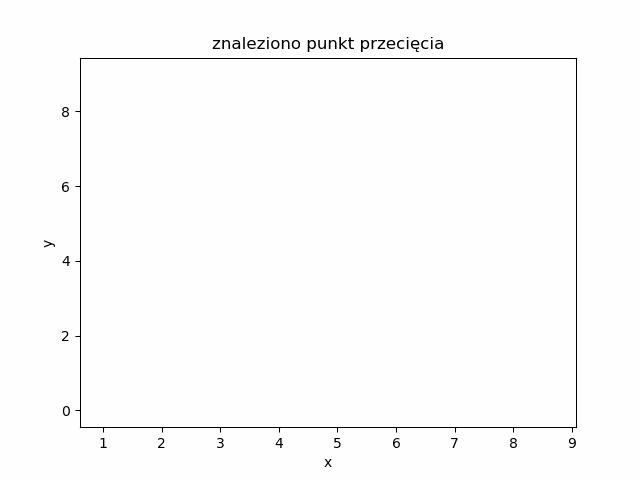

In [36]:
%matplotlib inline
isIntersection, vis = is_intersection_with_visualization(segments)
vis.show_gif(interval = 250)

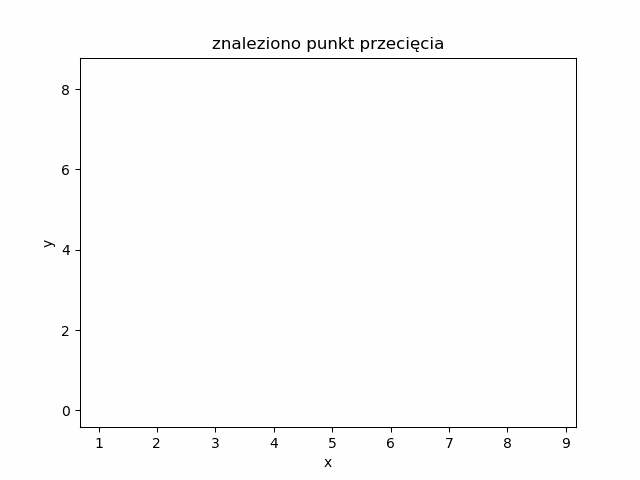

In [37]:
%matplotlib inline
isIntersection, vis = is_intersection_with_visualization(loadedSegments1)
vis.show_gif(interval = 250)

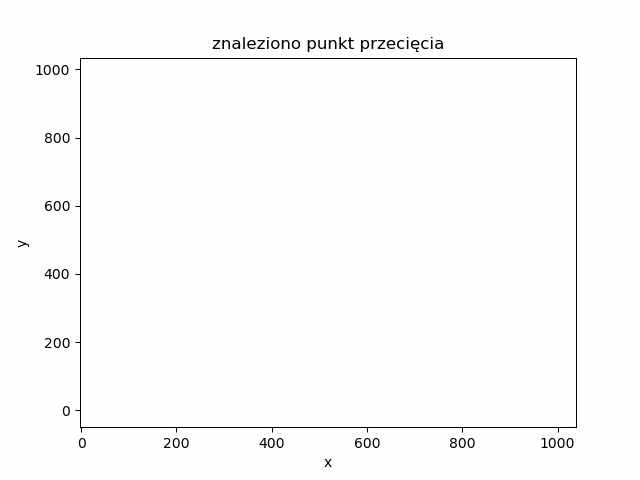

In [38]:
%matplotlib inline
isIntersection, vis = is_intersection_with_visualization(sections)
vis.show_gif(interval = 250)

Uzupełnij funkcję ```find_intersections```

In [39]:
def find_intersections_handle_event_beg(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                        intersections: set[tuple[float, float]]):

    # zaktualizowanie wartości x dla wszystkich odcinków
    Segment.update_x(event.get_event_point().get_x())

    eventSegment = event.get_event_segments_list()[0]

    broomStateStruct.add(eventSegment)

    eventSegmentIdx = broomStateStruct.bisect_left(eventSegment)

    assert(eventSegment == broomStateStruct[eventSegmentIdx])

    # sprawdzamy czy nowo wstawiony element ma poprzednika
    if eventSegmentIdx > 0:
        precedingSegment = broomStateStruct[eventSegmentIdx - 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, precedingSegment)

        if segmentsIntersectionPoint is not None and segmentsIntersectionPoint.get_point() not in intersections:
            intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [precedingSegment, eventSegment])
            intersections.add(segmentsIntersectionPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

    # sprawdzamy czy nowo wstawiony element ma następnika
    if eventSegmentIdx < len(broomStateStruct) - 1:
        succeedingSegment = broomStateStruct[eventSegmentIdx + 1]
        segmentsIntersectionPoint = get_segments_intersection(eventSegment, succeedingSegment)

        if segmentsIntersectionPoint is not None and segmentsIntersectionPoint.get_point() not in intersections:
            intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [eventSegment, succeedingSegment])
            intersections.add(segmentsIntersectionPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

In [40]:
def find_intersections_handle_event_end(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                        intersections: set[tuple[float, float]]):

    # # zaktualizowanie wartości x dla wszystkich odcinków
    Segment.update_x(event.get_event_point().get_x())


    toRemoveSegment = event.get_event_segments_list()[0]
    toRemoveSegmentIdx = broomStateStruct.bisect_left(toRemoveSegment)

    assert(toRemoveSegment == broomStateStruct[toRemoveSegmentIdx])

    precedingSegmentIdx = toRemoveSegmentIdx - 1
    succeedingSegmentIdx = toRemoveSegmentIdx + 1

    # sprawdzenie czy po usunięciu obecnego odcinka nowi sąsiedzi przecinają się
    if precedingSegmentIdx >= 0 and succeedingSegmentIdx < len(broomStateStruct):
        precedingSegment = broomStateStruct[precedingSegmentIdx]
        succeedingSegment = broomStateStruct[succeedingSegmentIdx]
        neighboursIntersectPoint = get_segments_intersection(precedingSegment, succeedingSegment)

        if neighboursIntersectPoint is not None and neighboursIntersectPoint.get_point() not in intersections:
            intersectionEvent = Event(neighboursIntersectPoint, eventType = INTERSECT, segmentsList = [precedingSegment, succeedingSegment])
            intersections.add(neighboursIntersectPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

    broomStateStruct.remove(toRemoveSegment)

In [41]:
def find_intersections_handle_event_intersect(event: Event, eventsStateStruct: SortedSet, broomStateStruct: SortedSet,
                                              intersections: set[tuple[float, float]]):

    prevPrecedingSegment, prevSucceedingSegment = event.get_event_segments_list()

    prevPrecedingSegmentIdx = broomStateStruct.bisect_left(prevPrecedingSegment)

    succeedingSegment, precedingSegment = prevPrecedingSegment, prevSucceedingSegment


    succeedingSegmentIdx = prevPrecedingSegmentIdx + 1

    assert(broomStateStruct[prevPrecedingSegmentIdx] == prevPrecedingSegment and broomStateStruct[succeedingSegmentIdx] == prevSucceedingSegment)

    if succeedingSegmentIdx < len(broomStateStruct) - 1:
        topNeighbour = broomStateStruct[succeedingSegmentIdx + 1]

        segmentsIntersectionPoint = get_segments_intersection(succeedingSegment, topNeighbour)
        if segmentsIntersectionPoint is not None and segmentsIntersectionPoint.get_point() not in intersections:
            intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [succeedingSegment, topNeighbour])
            intersections.add(segmentsIntersectionPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

    precedingSegmentIdx = prevPrecedingSegmentIdx

    if precedingSegmentIdx > 0:
        bottomNeighbour = broomStateStruct[precedingSegmentIdx - 1]

        segmentsIntersectionPoint = get_segments_intersection(bottomNeighbour, precedingSegment)
        if segmentsIntersectionPoint is not None and segmentsIntersectionPoint.get_point() not in intersections:
            intersectionEvent = Event(segmentsIntersectionPoint, eventType = INTERSECT, segmentsList = [bottomNeighbour, precedingSegment])
            intersections.add(segmentsIntersectionPoint.get_point())
            eventsStateStruct.add(intersectionEvent)

    ####### zamiana odcinków miejscami  #######

    broomStateStruct.pop(prevPrecedingSegmentIdx)
    broomStateStruct.pop(prevPrecedingSegmentIdx)

    currentEventX = event.get_event_point().get_x()

    nextEvent: Event = eventsStateStruct[0]
    nextEventX = nextEvent.get_event_point().get_x()

    middleX = (currentEventX + nextEventX) / 2

    Segment.update_x(middleX)

    broomStateStruct.add(precedingSegment)
    broomStateStruct.add(succeedingSegment)

    ####### koniec zamiany #######

In [42]:
def find_intersections(segments, eps = EPS):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków
    :param segments: tablica odcinków w postaci krotek krotek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """

    intersections = set()

    eventsSortedSet = SortedSet()
    broomStateStruct = SortedSet()

    segmentsObjects = [Segment(i, Point(segments[i][0]), Point(segments[i][1])) for i in range(len(segments))]

    for seg in segmentsObjects:
        eventBeg = Event(seg.get_beg(), eventType = BEG, segmentsList = [seg])
        eventEnd = Event(seg.get_end(), eventType = END, segmentsList = [seg])
        eventsSortedSet.add(eventBeg)
        eventsSortedSet.add(eventEnd)

    firstEvent: Event = eventsSortedSet.pop(0)
    broomStateStruct.add(firstEvent.get_event_segments_list()[0])
    prevEventX = firstEvent.get_event_point().get_x()

    while len(eventsSortedSet) > 0:
        event: Event = eventsSortedSet.pop(0)
        eventType = event.get_event_type()
        currentEventX = event.get_event_point().get_x()

        middleX = (prevEventX + currentEventX) / 2

        # zaktualizowanie obecnej wartości współrzędnej x
        Segment.update_x(middleX)

        if eventType == BEG:
            find_intersections_handle_event_beg(event, eventsSortedSet, broomStateStruct, intersections)
        elif eventType == END:
            find_intersections_handle_event_end(event, eventsSortedSet, broomStateStruct, intersections)
        elif eventType == INTERSECT:
            find_intersections_handle_event_intersect(event, eventsSortedSet, broomStateStruct, intersections)
        else:
            raise Exception("Unknow Event type")

        prevEventX = currentEventX

    return list(intersections)

In [43]:
def find_intersections_brute_force(segments, eps = EPS):
    segmentsObjects = [Segment(Point(beg), Point(end)) for beg, end in segments]
    n = len(segmentsObjects)

    intersectionsPoints = set()
    intersectionsTriplets = set()

    for i in range(n - 1):
        for j in range(i, n):
            intersectionPointObject = get_segments_intersection(segmentsObjects[i], segmentsObjects[j])
            if intersectionPointObject is not None:
                intersectionPoint = intersectionPointObject.get_point()
                intersectionTriplet = (intersectionPoint, i, j)
                if intersectionPoint in intersectionsPoints and intersectionTriplet not in intersectionsTriplets:
                    print("few lines intersect in the same point:")
                    print(intersectionPoint)
                    raise Exception("invalid input set")
                intersectionsTriplets.add(intersectionTriplet)
                intersectionsPoints.add(intersectionPoint)

    return list(intersectionsPoints)

Zwizualizujmy otrzymane przecięcia odcinków

[(np.float64(6.020889401586826), np.float64(1.137299358647511)), (np.float64(4.864786690563951), np.float64(5.2586180126609)), (np.float64(5.745370837354866), np.float64(6.553216769251949)), (np.float64(3.494323069369685), np.float64(3.2438185111969804)), (np.float64(4.684799706244717), np.float64(5.663199145162037)), (np.float64(5.0709874211703925), np.float64(5.561765883791777)), (np.float64(3.942353432834882), np.float64(7.332096233768344))]


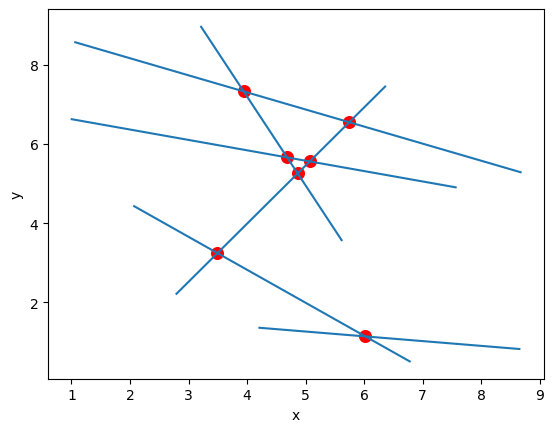

In [44]:
%matplotlib inline
intersections = find_intersections(segments)
print(intersections)
draw_intersections(segments, intersections)

[(np.float64(206.45310136120895), np.float64(958.9358047031692)), (np.float64(482.544063166831), np.float64(243.8703810855809)), (np.float64(954.2314285954535), np.float64(515.4286617551417)), (np.float64(363.3855732769578), np.float64(797.959341327209)), (np.float64(354.67354020556576), np.float64(759.2954078160703)), (np.float64(713.6613298656434), np.float64(490.19704145855775)), (np.float64(825.9143277174904), np.float64(191.72299277511573)), (np.float64(554.1031660969114), np.float64(319.81819503687836)), (np.float64(660.6640405583106), np.float64(752.5539097840634)), (np.float64(482.60711845745215), np.float64(243.47353279711612)), (np.float64(569.818879096762), np.float64(598.021791017363)), (np.float64(295.6692675265111), np.float64(803.5251945758973)), (np.float64(861.8821794032723), np.float64(671.9725971922146)), (np.float64(953.2588079597732), np.float64(561.210506655798)), (np.float64(410.7852267547969), np.float64(562.57535727577)), (np.float64(420.74126953878863), np.flo

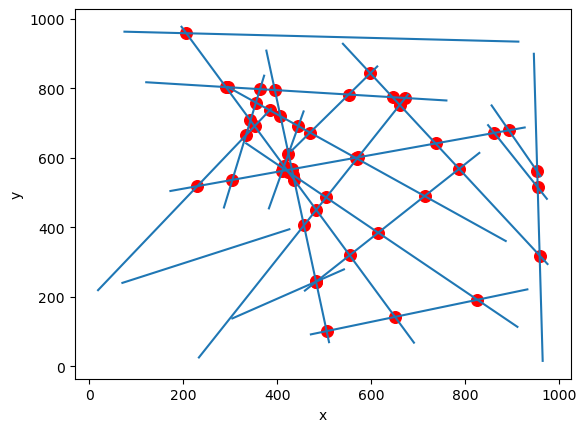

In [45]:
%matplotlib inline
loadedSegments2 = load_segments_from_file("./test_segments/test4")
intersections = find_intersections(loadedSegments2)
print(intersections)
draw_intersections(loadedSegments2, intersections)

0
[(597.307735013118, 396.1700539069271), (667.0299396109751, 399.1205103587388), (328.4310542916561, 902.0083008404661), (524.0219493020663, 626.2049186549835), (465.79798952297875, 584.7877842718736), (599.4721993655794, 679.875832793705), (433.1422003765689, 618.5987550456193), (545.5095522153958, 502.25646633496785), (386.42806480215677, 289.7079748972024), (647.64019618481, 349.08492751819824), (318.11514959232534, 479.73481208147814), (402.3875002457895, 795.3807462365951), (480.84637038031036, 415.2152393490157), (660.7567575404001, 382.93245081265485), (273.8434268262974, 472.30155256592184), (611.3704344495548, 255.4901527950776), (545.9690323994146, 501.78073227742203), (704.1115834089742, 428.17128774708914), (287.46208327246137, 457.9300057467468), (628.1156193649691, 610.9755896831797), (417.8075819907992, 550.65020301835), (647.3368284710733, 636.5257344309755), (444.46258435535026, 366.85142444648017), (762.7729750331754, 646.1871411532331), (441.35341342738093, 176.9567

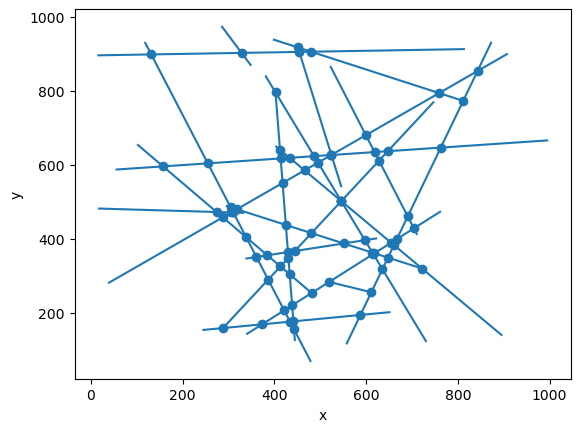

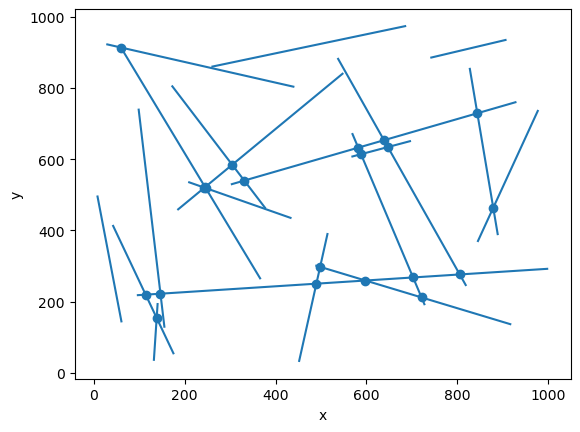

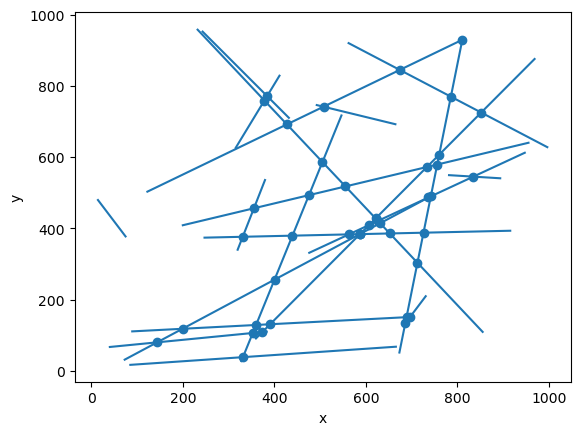

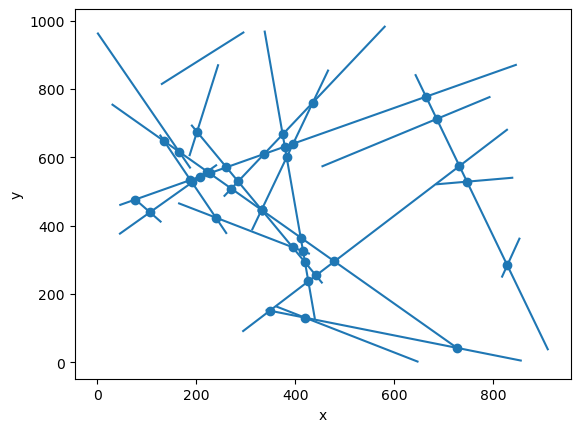

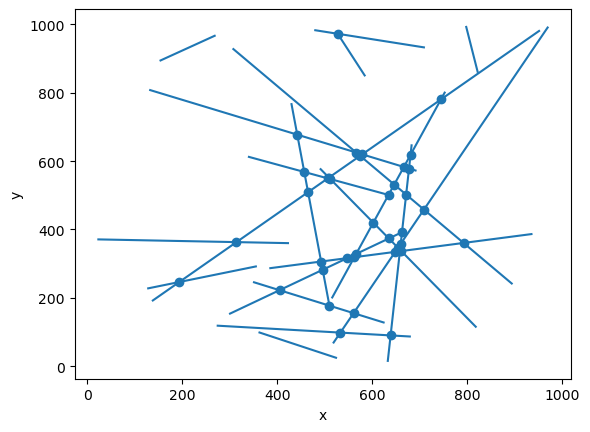

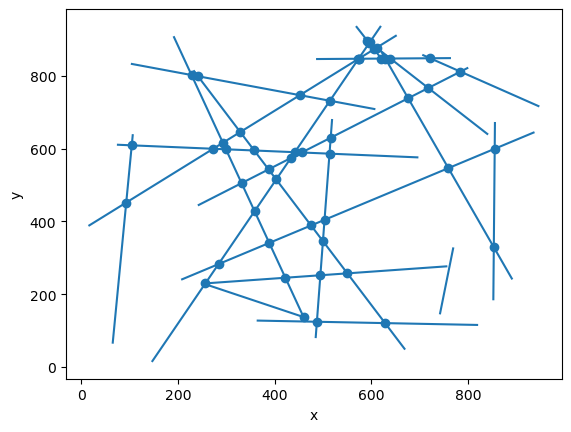

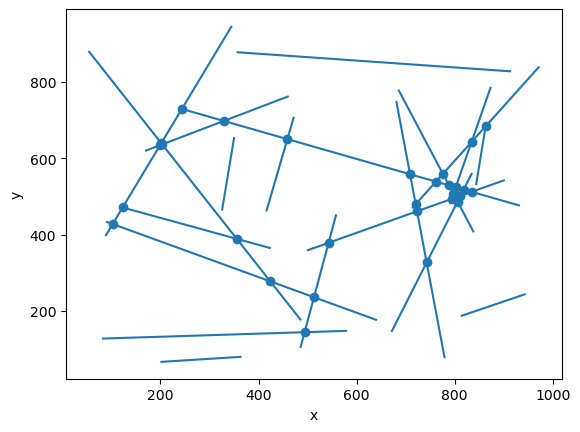

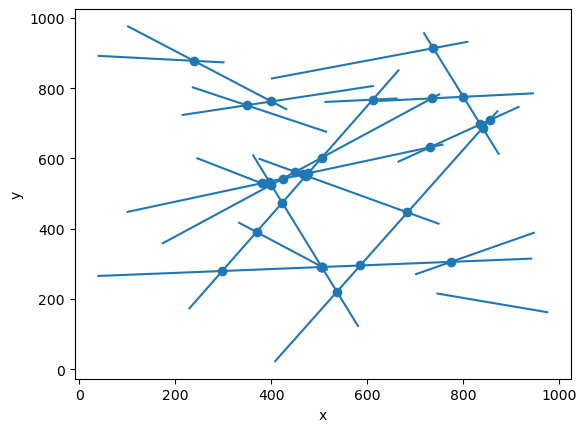

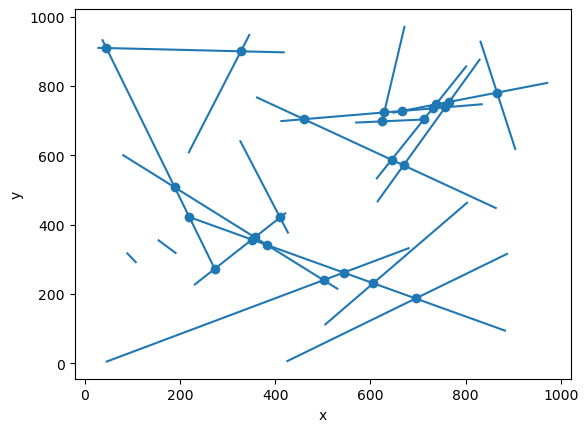

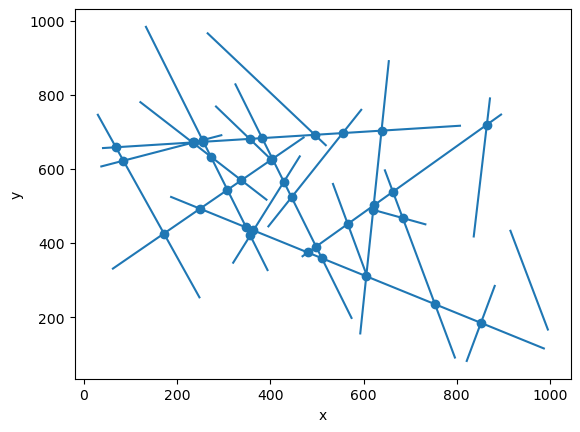

In [48]:
# TODO: remove
for i in range(10):
    vis = Visualizer()
    print(i)
    sections = generate_uniform_sections(1000, 1000, 20)
    vis.add_line_segment(sections)
    intersections = find_intersections(sections)
    vis.add_point(intersections)
    vis.show()
    print(intersections)

In [47]:
Test().runtest(3, find_intersections)

Lab 4, task 3:
	Test 1: 

IndexError: tuple index out of range

Uzupełnij funkcję ```find_intersections_with_visualization```

In [ ]:
def find_intersections_with_visualization(sections):
    """
    Funkcja znajduje wszystkie przecięcia zadanych odcinków i dodatkowo zwraca kolejne kroki w wizualizacji
    :param sections: tablica odcinków w postaci krotek ktorek współrzędnych punktów końcowych odcinków
    :return: tablica punktów przecięć w postaci trzyelementowych krotek w których pierwszym elementem są współrzędne danego punktu, a drugim i trzecim indeksy prostych z listy wejściowej, które się przecinają w tym punkcie współrzędnych np.:
    [((x1, y1), id1,id2),
    ((x2, y2), id3, id4),
    ...]
    """

### Czy konieczne były zmiany w strukturze zdarzeń. Jeśli tak, to jakie? Czy w przypadku obu algorytmów konieczne są takie same struktury zdarzeń?
### Odpowiedź uzasadnij. 

In [ ]:
# Odpowiedź here

### Jak obsługiwane są zdarzenia początku odcinka, końca odcinka i przecięcia odcinków z uwzględnianiem wybranych struktur danych?

In [ ]:
# Odpowiedź here

### Samemu zaprojektuj test, który uwzględnia taki układ odcinków, przy którym pewne przecięcia będą wykrywane więcej niż jeden raz

In [ ]:
# testing_sections = ???

In [ ]:
### Czy Twój program uwzględnia powyższy przypadek? Jeśli tak, to jak?

In [ ]:
# Odpowiedź here

### Zadanie dodatkowe
Zaimplementuj inną strukturę stanu. Opisz ją w sprawozdaniu. Porównaj efektywność algorytmu dla obu struktur robiąc testy na odpowiednio dużych zestawach odcinków.